In [1]:
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import sklearn.metrics as metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras import models

In [2]:
rm -rf ./untitled_project/

In [3]:
!pip install imgaug==0.4.0
!pip install imgo
!pip install keras-tuner

     |████████████████████████████████| 948 kB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 31.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 96 kB 4.5 MB/s eta 0:00:011
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9563 sha256=ef0b61043ae6cb2972b0ef074c0d60ac06378b6f8d32152353095c2b958d291c
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [4]:
from imgo import uptools
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.tuners import Hyperband
from keras_tuner.tuners import RandomSearch

In [5]:
class_names = ['amethyst_deceiver',
               'bolete',
               'chanterelle',
               'chicken_of_the_woods',
               'death_cap',
               'false_chanterelle',
               'false_morel',
               'fibrecap',
               'field_mushroom',
               'fly_agaric',
               'giant_puffball',
               'grey_oyster',
               'morel',
               'orange_peel',
               'roundhead',
               'saddle',
               'shaggy_inkcap',
               'stinkhorn',
               'waxcap',
               'yellow_stainer']


In [6]:
%%time
ds = uptools.Image_Dataset("/floyd/input/ds_1", "h5", 256, normalize=True, manual_classes=class_names)

Processing X_test: 100%|██████████| 1300/1300 [00:00<00:00, 1856.69it/s]


Normalizing...
Image_Datset initialized successfully.
CPU times: user 11.5 s, sys: 6.41 s, total: 17.9 s
Wall time: 38.1 s


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


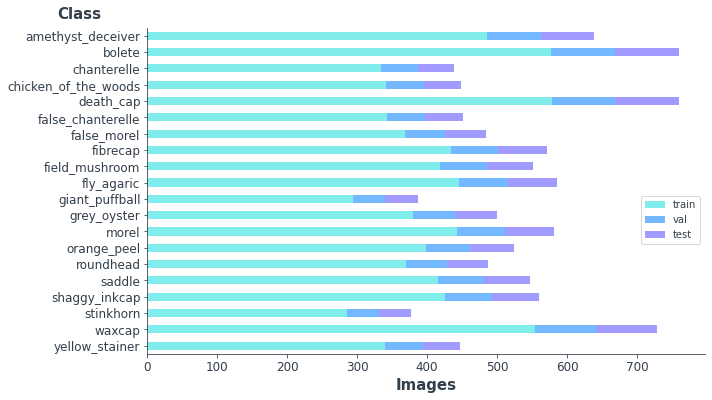

In [7]:
ds.details(plot=True)

In [12]:
class CNNHyperModel(HyperModel):
    def __init__(self,input_shape,class_no):
        self.input_shape = input_shape
        self.num_classes = class_no

    def build(self,hp):

        inputs = keras.Input(shape=self.input_shape)
        x = layers.Conv2D(32,(3,3),padding='same',activation='relu',kernel_initializer='he_uniform')(inputs)
        x = layers.MaxPooling2D((2,2))(x)

        x = layers.Conv2D(64,(3,3),padding='same',activation='relu',kernel_initializer='he_uniform')(x)
        x = layers.MaxPooling2D((2,2))(x)

        x = layers.Conv2D(128,(3,3),padding='same',activation='relu',kernel_initializer='he_uniform')(x)
        x = layers.MaxPooling2D((2,2))(x)

        x = layers.Conv2D(256,(3,3),padding='same',activation='relu',kernel_initializer='he_uniform')(x)
        x = layers.MaxPooling2D((2,2))(x)

        x = layers.Conv2D(512,(3,3),padding='same',activation='relu',kernel_initializer='he_uniform')(x)
        x = layers.MaxPooling2D((2,2))(x)

        x = layers.Flatten()(x)
        x = layers.Dense(1024,activation='relu',kernel_initializer='he_uniform')(x)  
        x = layers.Dropout(0.15)(x)

        x = layers.Dense(2048,activation='relu',kernel_initializer='he_uniform')(x) 
        x = layers.Dropout(0.25)(x)

        x = layers.Dense(20)(x)
        outputs = layers.Activation('softmax')(x)

        nadam = optimizers.Nadam(learning_rate=hp.Choice("learning_rate",values=[0.0001,0.00007,0.00005]))
        adamax = optimizers.Adamax(learning_rate=hp.Choice("learning_rate",values=[0.0001,0.00007,0.00005]))
        
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(loss='categorical_crossentropy',optimizer=nadam,metrics=['accuracy'])
        model.summary()

        return model
    
hypermodel = CNNHyperModel(ds.img_shape,ds.class_no)

In [13]:
n_epochs = 4
s_batch = 32
m_trials = 3

In [14]:
%%time
# tuner = BayesianOptimization(hypermodel,max_trials=m_trials,objective='val_accuracy')
# tuner = Hyperband(hypermodel,objective='val_accuracy',max_epochs=8)

tuner = RandomSearch(hypermodel,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=3)



tuner.search(ds.X_train,
             ds.y_train,
             epochs=n_epochs,
             validation_data=(ds.X_val,ds.y_val),
             batch_size=s_batch)

Trial 3 Complete [00h 10m 23s]
val_accuracy: 0.5392307639122009

Best val_accuracy So Far: 0.5684615174929301
Total elapsed time: 00h 31m 08s
INFO:tensorflow:Oracle triggered exit
CPU times: user 18min 16s, sys: 8min 54s, total: 27min 10s
Wall time: 31min 8s


In [15]:
tuner.results_summary()
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(ds.X_val, ds.y_val)

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 7e-05
Score: 0.5684615174929301
Trial summary
Hyperparameters:
learning_rate: 0.0001
Score: 0.5392307639122009
Trial summary
Hyperparameters:
learning_rate: 5e-05
Score: 0.5366666714350382
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
________________________________

In [ ]:
(val_loss, val_acc) = best_model.evaluate(ds.X_val,ds.y_val,verbose=1)
print('---')
print(f'Val Loss: {val_loss}')
print(f'Val Accuracy: {val_acc}')